# Import necessary libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import time
import copy
import lightgbm as lgb
import os

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [7]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
MIIV_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_static.parquet"
MIIV_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_dynamic.parquet"

## Preprocessing

In [8]:
def preprocess(DYNAMIC_PATH, STATIC_PATH):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    # Detect -inf values in DataFrame day1
    #inf_mask = df_day1.isin([-np.inf])
    # Add an indicator column based on whether -inf was replaced
    #df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
    # Replace -inf with NaN
    df_day1.replace(-np.inf, np.nan, inplace=True)
    
    # Perform an inner join on the 'stay_id' column
    df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
    df.rename(columns={'hr_x': 'hr3',
                       'hr_y': 'hr1'}, inplace=True)
    
    df.dropna(subset=["hr3", "hr1"], inplace=True)

    # Create a new DataFrame to hold the indicators
    #indicators = df.isna().astype(int)

    # Rename the indicator columns to distinguish them
    #indicators.columns = [str(col) + '_was_nan' for col in df.columns]

    # Replace NaN values with the mean of the column
    #for column in df.columns:
    #    df[column].fillna(df[column].mean(), inplace=True)

    # Concatenate the original DataFrame with the indicator DataFrame
    #df = pd.concat([df, indicators], axis=1)

    return df

In [10]:
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

In [11]:
df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)

In [12]:
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

In [13]:
df_miiv = preprocess(MIIV_DATA_PATH_DYNAMIC, MIIV_DATA_PATH_STATIC)

## Automated EDA

In [ ]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Random Forest Prediction

In [14]:
def plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm, name):
    plt.figure(figsize=(10, 6))
    #plt.plot(n_test_range, mse_values_rf, '-o', label='Random Forest', linewidth=2, color='blue')
    plt.plot(n_test_range, mse_values_lgbm, '-o', label='LightGBM', linewidth=2, color='green')
    plt.title(f"MSE vs Number of tuning Data Points from {name}")
    plt.xlabel("Number of tuning Points")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    filename = f'eicuTO{name}.png'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    plt.show()

In [22]:
def lgbm_feature_importance(lgbm_feature_importances, df_train, n_test_points=0):
    # Feature importance extraction for LGBM
    feature_names = df_train.columns.tolist()
    lgbm_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_feature_importances})
    lgbm_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=lgbm_importances_df)
    if n_test_points == 0: 
        plt.title('LGBM Train Feature Importances')
    else: 
        plt.title(f'LGBM Feature Importances after fine-tuning with {n_test_points} data points')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [65]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
df_eicu, df_hirid, df_mimic, df_miiv

In [85]:
X_train = df_eicu.drop('hr3', axis=1)
y_train = df_eicu['hr3']

In [93]:
# Pipelines for both RandomForest and LGBM
pipeline_rf = Pipeline([
    ('rf', lgb.LGBMRegressor(random_state=42, boosting_type="rf"))
])

pipeline_lgbm = Pipeline([
    ('lgbm', lgb.LGBMRegressor(random_state=42, boosting_type='gbdt'))
])

#pipeline_rf.fit(X_train,y_train)
pipeline_lgbm.fit(X_train,y_train)

print(f"Training finished \n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 74648, number of used features: 52
[LightGBM] [Info] Start training from score 84.928584
Training finished 



In [ ]:
lgbm_feature_importance(pipeline_lgbm.named_steps['lgbm'].feature_importances_, X_train)

In [94]:
#y_pred_insample_rf = pipeline_rf.predict(X_train)
y_pred_insample_lgbm = pipeline_lgbm.predict(X_train)
    
print(f"Predicting finished \n")

Predicting finished 



In [95]:
#in_sample_mse_rf = mean_squared_error(y_train, y_pred_insample_rf)
#print(f"In sample RF MSE: {in_sample_mse_rf}")
in_sample_mse_lgbm = mean_squared_error(y_train, y_pred_insample_lgbm)
print(f"In sample LGBM MSE: {in_sample_mse_lgbm}")

In sample LGBM MSE: 132.48582552017447


In [107]:
X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic.drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv} \n')

Do nothing-mse on Hirid is 278.0011333281888, on Mimic is 548.8081578499456, on Miiv is 243.3661983075155 



### Hypothesis: Bad performance of Eicu on Mimic is caused by children

In [108]:
X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic[df_mimic["age"]>18].drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic[df_mimic["age"]>18]['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic (without children) is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv} \n')

Do nothing-mse on Hirid is 278.0011333281888, on Mimic (without children) is 226.98293268716793, on Miiv is 243.3661983075155 



In [ ]:
""""""""""
Do only if access to Euler otherwise pc goes in brrrr state
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)
#best_training_model = grid_search.best_estimator_
#print("Finished grid search and selected best estimator \n")
"""""""""""

## Eicu to Hirid

In [99]:
# When n_test is 0, use the entire X_test and y_test for evaluation without further splitting
X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test_hirid, [], y_test_hirid
mse_values_rf = []
mse_values_lgbm = []
n_fine_tune_range = [0, 25, 50, 100, 200, 400, 800, 1600]

for n_fine_tune in n_fine_tune_range:
    print(f"Currently in n_fine_tune= {n_fine_tune}")

    # LightGBM fine-tuning and evaluation
    copied_model_lgbm = copy.deepcopy(pipeline_lgbm.named_steps['lgbm'])
    
    if n_fine_tune > 0:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test_hirid, y_test_hirid, train_size=n_fine_tune, random_state=42)
        copied_model_lgbm.fit(X_fine_tune, y_fine_tune)

    y_pred_lgbm = copied_model_lgbm.predict(X_evaluate)    
    mse_values_lgbm.append(mean_squared_error(y_evaluate, y_pred_lgbm))
    #lgbm_feature_importance(copied_model_lgbm.feature_importances_, X_train, n_fine_tune)

plot_mse_vs_tuning_points(n_fine_tune_range, mse_values_rf, mse_values_lgbm, "hirid")

Currently in n_fine_tune= 0
Currently in n_fine_tune= 25


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'min_child_samples'

## Eicu to Mimic

Currently in n_test= 0
len(X_fine_tune)=0
n_fine_tune=0
len(X_test)=30335
Currently in n_test= 25
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 93.567686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

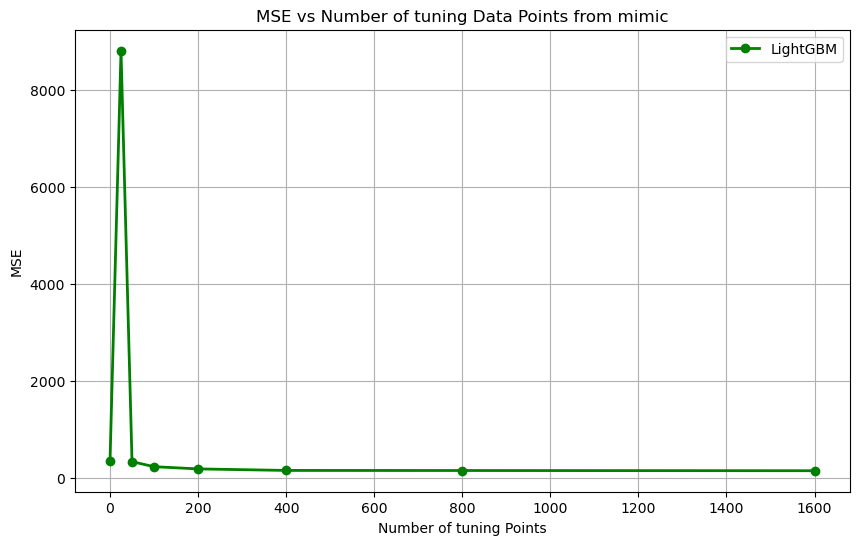

In [70]:
# When n_test is 0, use the entire X_test and y_test for evaluation without further splitting
X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test_mimic, [], y_test_mimic
mse_values_rf = []
mse_values_lgbm = []
n_fine_tune_range = [0, 25, 50, 100, 200, 400, 800, 1600]

for n_fine_tune in n_fine_tune_range:
    print(f"Currently in n_test= {n_fine_tune}")

    # Random Forest fine-tuning and evaluation
    #copied_model_rf = clone(pipeline_rf.named_steps['rf])
    # LightGBM fine-tuning and evaluation
    copied_model_lgbm = copy.deepcopy(pipeline_lgbm.named_steps['lgbm'])
    
    if n_fine_tune > 0:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test_mimic, y_test_mimic, train_size=n_fine_tune, random_state=42)
        copied_model_lgbm.fit(X_fine_tune, y_fine_tune)
        #copied_model_rf.fit(X_fine_tune, y_fine_tune)


    print(f"len(X_fine_tune)={len(X_fine_tune)}")
    print(f"n_fine_tune={n_fine_tune}")
    print(f"len(X_test)={len(X_test_mimic)}")
    #y_pred_rf = copied_model_rf.predict(X_evaluate)
    y_pred_lgbm = copied_model_lgbm.predict(X_evaluate)
    
    #mse_values_rf.append(mean_squared_error(y_evaluate, y_pred_rf))
    mse_values_lgbm.append(mean_squared_error(y_evaluate, y_pred_lgbm))

    #lgbm_feature_importance(copied_model_lgbm.feature_importances_, X_train, n_fine_tune)

plot_mse_vs_tuning_points(n_fine_tune_range, mse_values_rf, mse_values_lgbm, "mimic")

## Eicu to Miiv

Currently in n_test= 0
len(X_fine_tune)=0
n_fine_tune=0
len(X_test)=35673
Currently in n_test= 25
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 87.393596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

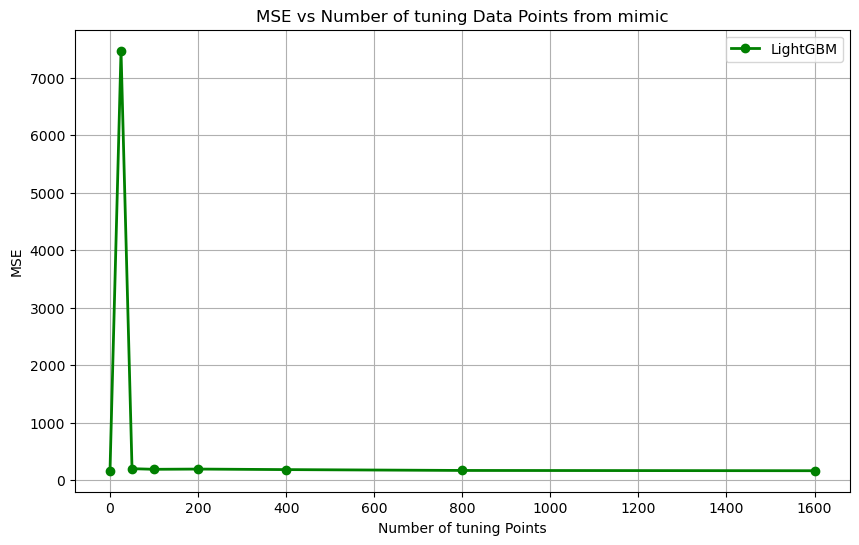

In [71]:
# When n_test is 0, use the entire X_test and y_test for evaluation without further splitting
X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test_miiv, [], y_test_miiv
mse_values_rf = []
mse_values_lgbm = []
n_fine_tune_range = [0, 25, 50, 100, 200, 400, 800, 1600]

for n_fine_tune in n_fine_tune_range:
    print(f"Currently in n_test= {n_fine_tune}")

    # Random Forest fine-tuning and evaluation
    #copied_model_rf = clone(pipeline_rf.named_steps['rf])
    # LightGBM fine-tuning and evaluation
    copied_model_lgbm = copy.deepcopy(pipeline_lgbm.named_steps['lgbm'])
    
    if n_fine_tune > 0:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test_miiv, y_test_miiv, train_size=n_fine_tune, random_state=42)
        copied_model_lgbm.fit(X_fine_tune, y_fine_tune)
        #copied_model_rf.fit(X_fine_tune, y_fine_tune)


    print(f"len(X_fine_tune)={len(X_fine_tune)}")
    print(f"n_fine_tune={n_fine_tune}")
    print(f"len(X_test)={len(X_test_miiv)}")
    #y_pred_rf = copied_model_rf.predict(X_evaluate)
    y_pred_lgbm = copied_model_lgbm.predict(X_evaluate)
    
    #mse_values_rf.append(mean_squared_error(y_evaluate, y_pred_rf))
    mse_values_lgbm.append(mean_squared_error(y_evaluate, y_pred_lgbm))

    #lgbm_feature_importance(copied_model_lgbm.feature_importances_, X_train, n_fine_tune)

plot_mse_vs_tuning_points(n_fine_tune_range, mse_values_rf, mse_values_lgbm, "mimic")